In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import timedelta, datetime
year_plus_one = timedelta(days=366)
from dateparser import parse

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes['measurement']
station = Base.classes['station']

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

last_date
last_date_string = str(last_date)
last_date_date = parse(last_date_string)

# The query to sql is not inclusive of the date, so have added one to the date (above)
# so result will include a full year of data.

one_year = last_date_date - year_plus_one

print(last_date_date, one_year)

2017-08-23 00:00:00 2016-08-22 00:00:00


In [11]:
# Perform a query to retrieve the data and precipitation scores

results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > one_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame

last_year_rain = pd.DataFrame(results, columns=['date', 'precipitation'])

last_year_rain['date'] = pd.to_datetime(last_year_rain['date'])

# Sort the dataframe by date
last_year_rain.sort_values(by='date')

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2228,2017-08-23,0.08
2226,2017-08-23,0.00
2227,2017-08-23,0.00


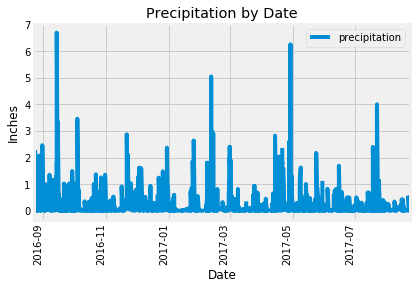

In [12]:
# Plot the results using the DataFrame `plot` method.

ax = last_year_rain.plot(x='date', rot=90, title='Precipitation by Date')
ax.set_ylabel("Inches")
ax.set_xlabel("Date")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for ALL of the last year's precipitation data.

last_year_rain.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?

len(engine.execute("select distinct station from measurement").fetchall())

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp_min = session.query(measurement.station, func.min(measurement.tobs)).\
    filter_by(station='USC00519281').order_by(func.min(measurement.station).desc()).all()

temp_max = session.query(measurement.station, func.max(measurement.tobs)).\
    filter_by(station='USC00519281').order_by(func.min(measurement.station).desc()).all()

temp_avg = session.query(measurement.station, func.avg(measurement.tobs)).\
    filter_by(station='USC00519281').order_by(func.min(measurement.station).desc()).all()

print(temp_min, temp_max, temp_avg)

[('USC00519281', 54.0)] [('USC00519281', 85.0)] [('USC00519281', 71.66378066378067)]


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(measurement.tobs).\
    filter(measurement.date > one_year, measurement.station == 'USC00519281').\
    all()

# Save the query results as a Pandas DataFrame
tobs = pd.DataFrame(tobs_data, columns=['tobs'])

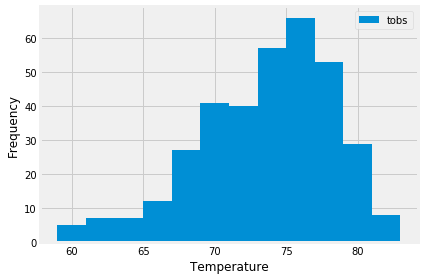

In [18]:
x = tobs['tobs'] 

plt.hist(x, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.legend(labels = ["tobs"], loc="best")
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vacation_temps = (calc_temps('2017-02-16', '2017-02-23'))

vacation_temps[0][1]

70.875

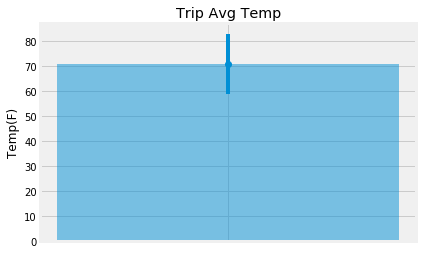

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = [""]
y = vacation_temps[0][1]
error = [vacation_temps[0][0] - vacation_temps[0][2]]

plt.bar(x, y, align='center', alpha=0.5)
plt.errorbar(x, y, yerr=error, fmt='o')

plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_rainfall(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.sum(measurement.prcp), measurement.station, station.name, station.latitude,\
       station.longitude,station.elevation).filter(measurement.station == station.station).\
        filter(measurement.date >= start_date).\
        filter(measurement.date <= end_date).group_by(measurement.station).\
        order_by(func.sum(measurement.prcp).desc()).all()

# function usage example
calc_rainfall('2017-02-16', '2017-02-23')

[(1.01,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.87,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.8600000000000001,
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 (0.7899999999999999,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.6200000000000001,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (0.2, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.17, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_date = '2017-02-16'
end_date = '2017-02-23'

# Use the start and end date to create a range of dates

datelist = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings

md_datelist = []

for date in datelist:
    md_datelist.append(date.strftime("%m-%d"))
    
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for date in md_datelist:
    normals.append(daily_normals(date))
    
normals

[[(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76.0)],
 [(63.0, 69.79629629629629, 76.0)],
 [(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# add the returned objects into a DF
trip_temp = pd.DataFrame(list(normals), columns = ['combined_temps'])

# add the dates
trip_temp['dates'] = datelist

# make the dates into datetime format
trip_temp['dates'] = pd.DatetimeIndex(trip_temp['dates'])

# set the date as the index
trip_temp.set_index('dates', inplace = True)

# make new df with the combined temperature objects into new columns using join
trip_temp_df = trip_temp.join(pd.DataFrame([*trip_temp.combined_temps], trip_temp.index, [*'efg']))

# drop the column with combined temperatures
trip_temp_df.drop(['combined_temps'], axis=1, inplace = True)

# rename the columns
trip_temp_df.rename(columns={'e': 'tmin', 'f': 'tavg', 'g': 'tmax'}, inplace = True)

# display the columns
trip_temp_df

,tmin,tavg,tmax
dates,,,
2017-02-16,59.0,70.482143,76.0
2017-02-17,62.0,70.472727,77.0
2017-02-18,63.0,70.796296,77.0
2017-02-19,60.0,69.339623,77.0
2017-02-20,63.0,70.140351,76.0
2017-02-21,63.0,69.796296,76.0
2017-02-22,60.0,70.157895,83.0
2017-02-23,62.0,70.355932,81.0


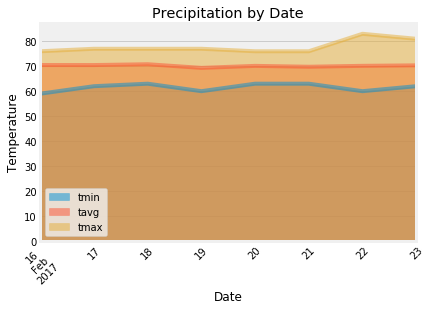

In [26]:
# Plot the daily normals as an area plot with `stacked=False`

trip_temp_df.plot.area(stacked=False, rot=45, title='Precipitation by Date')

plt.ylabel('Temperature')
plt.xlabel('Date')

plt.show()